In [1]:
from __future__ import division, print_function, absolute_import

import tflearn
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.normalization import local_response_normalization
from tflearn.layers.estimator import regression
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import h5py
from tflearn.data_preprocessing import ImagePreprocessing
from tflearn.data_augmentation import ImageAugmentation

%matplotlib inline

In [2]:
IMG_WIDTH = 32 # Side for each transformed Image
IMG_HEIGHT = 32
IMG_DEPTH = 1 # RGB files

In [3]:
NUM_LABELS = 2
h5FileName = 'svhn_' + str(NUM_LABELS) + '.h5'

In [4]:
data = h5py.File(h5FileName)
imgs = np.array(data['images']).astype(float)
labels = np.array(data['digits'])

In [5]:
print (type(imgs))
print (labels.shape)
print (imgs.shape)

<type 'numpy.ndarray'>
(56, 2)
(56, 32, 64, 3)


[3 8]


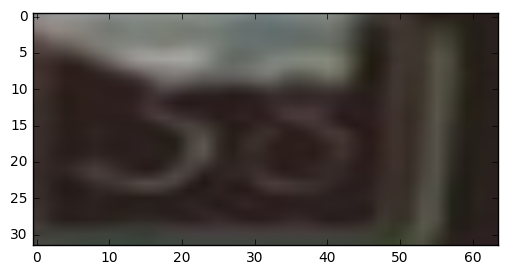

In [6]:
print (labels[0])
plt.imshow(imgs[0])

In [7]:
def dense_to_one_hot(labels_dense, num_classes=10):
    """Convert class labels from scalars to one-hot vectors."""
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    index_update = [int(x) for x in index_offset + labels_dense.ravel()]
    labels_one_hot.flat[index_update] = 1
    return labels_one_hot

In [8]:
# Get the dataset
X = imgs.reshape([-1, IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH])
Y = labels

In [9]:
# Generate validation set
ratio = 0.9 # Train/Test set
randIdx = np.random.random(imgs.shape[0]) <= ratio
#print (sum(map(lambda x: int(x), randIdx)))
X_train = X[randIdx]
Y_train = Y[randIdx]
X_test = X[randIdx == False]
Y_test = Y[randIdx == False]
Y_train = [dense_to_one_hot(Y_train[:,idx], num_classes= 10) for idx in range(Y_train.shape[1])] 
Y_test = [dense_to_one_hot(Y_test[:,idx], num_classes= 10) for idx in range(Y_test.shape[1])] 
#del X, Y # release some space

/home/ankdesh/installed/anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 336 but corresponding boolean dimension is 56
/home/ankdesh/installed/anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 336 but corresponding boolean dimension is 56


In [10]:
print (X_train.shape)
print (Y_train[0].shape)

(48, 32, 32, 1)
(48, 10)


print (np.mean(Y_train[1], axis = 0))

In [11]:
# Building convolutional network

# Building convolutional network
for numLayers in [1,2,3,4,5]: # Num of Conv layer sets to use
    with tf.Graph().as_default():
        
        # Real-time data preprocessing
        img_prep = ImagePreprocessing()
        img_prep.add_featurewise_zero_center()
        img_prep.add_featurewise_stdnorm()

        # Real-time data augmentation
        img_aug = ImageAugmentation()
        #img_aug.add_random_flip_leftright()
        img_aug.add_random_rotation(max_angle=25.)
        input = input_data(shape=[None, IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH], name='input',
                                                                    data_preprocessing=img_prep,
                                                                    data_augmentation=img_aug)

        # Building convolutional network
        x = tflearn.conv_2d(input, 32, 3, activation='relu', name='conv1_1')
        x = tflearn.conv_2d(x, 32, 3, activation='relu', name='conv1_2')
        x = tflearn.max_pool_2d(x, 2, strides=2, name='maxpool1')
        #x = local_response_normalization(x)

        if numLayers >= 2:
            x = tflearn.conv_2d(x, 64, 3, activation='relu', name='conv2_1')
            x = tflearn.conv_2d(x, 64, 3, activation='relu', name='conv2_2')
            x = tflearn.max_pool_2d(x, 2, strides=2, name='maxpool2')
            #x = local_response_normalization(x)
    
        if numLayers >= 3:
            x = tflearn.conv_2d(x, 256, 3, activation='relu', name='conv3_1')
            x = tflearn.conv_2d(x, 256, 3, activation='relu', name='conv3_2')
            x = tflearn.conv_2d(x, 256, 3, activation='relu', name='conv3_3')
            x = tflearn.max_pool_2d(x, 2, strides=2, name='maxpool3')

        if numLayers >= 4:
            x = tflearn.conv_2d(x, 512, 3, activation='relu', name='conv4_1')
            x = tflearn.conv_2d(x, 512, 3, activation='relu', name='conv4_2')
            x = tflearn.conv_2d(x, 512, 3, activation='relu', name='conv4_3')
            x = tflearn.max_pool_2d(x, 2, strides=2, name='maxpool4')

        if numLayers >= 5:
            x = tflearn.conv_2d(x, 512, 3, activation='relu', name='conv5_1')
            x = tflearn.conv_2d(x, 512, 3, activation='relu', name='conv5_2')
            x = tflearn.conv_2d(x, 512, 3, activation='relu', name='conv5_3')
            x = tflearn.max_pool_2d(x, 2, strides=2, name='maxpool5')

        # Training heads
        allHeads = []
        for idx in range(NUM_LABELS):
            fc = fully_connected(x, 1024, activation='tanh')
            #fc = dropout(fc, 0.8)
            #fc = fully_connected(fc, 1024, activation='tanh')
            #fc = dropout(fc, 0.8)
            softmax = fully_connected(fc, 10, activation='softmax')
            networkOut = regression(softmax, optimizer='adam', learning_rate=0.001,
                         loss='categorical_crossentropy', name='target' + str(idx))
            allHeads.append(networkOut)

        network = tflearn.merge(allHeads, mode='elemwise_sum')

        model = tflearn.DNN(network, tensorboard_verbose=1)
        feedTrainDict = {'target'+ str(i): Y_train[i] for i in range(NUM_LABELS)}
        #feedTrainDict = {'target0': Y_train[0]}
        feedTestList =  [Y_test[i] for i in range(NUM_LABELS)]
        #feedTestList =  Y_test[0]
        model.fit({'input': X_train}, feedTrainDict, 
                  validation_set= (X_test, feedTestList), n_epoch=1, show_metric=True, 
                  run_id='convnet_svhn_' + str(numLayers))
        #with open('/tmp/tflearn_logs/resultsLayer.txt','a') as f:
        #    strRes = str(numLayers) + ' -> ' + str(model.evaluate([X_test], feedTestList))
        #    f.write(strRes)
        #model.fit({'input': X_train}, feedTrainDict, n_epoch=1, show_metric=True, run_id='convnet_mnist')
        #model.fit({'input': X_train}, {'target0': Y_train[1]}, n_epoch=1, show_metric=True, run_id='convnet_mnist')
        #numImgEachAxis = 8
        #f,ax = plt.subplots(numImgEachAxis, numImgEachAxis, figsize=(10,10))
        #for i in range(numImgEachAxis):
        #    for j in range(numImgEachAxis):
        #        res = np.array([np.argmax(x) for x in model.predict([X_train[i*numImgEachAxis + j]])])
        #        print (str(i) + ',' + str(j) + ' -> ' +str(res))
                #ax[i][j].set_title(str([np.round(x,2) for x in res]))
        #        ax[i][j].imshow(X_train[i*numImgEachAxis + j].reshape((IMG_HEIGHT,IMG_WIDTH)) ,cmap = 'gray')
        #plt.show() # or display.display(plt.gcf()) if you prefer
    #    print (model.evaluate(X_test,feedTestList))

Training Step: 1 
| Adam_0 | epoch: 001 | loss: 0.00000 - acc: 0.0000 | val_loss: 2.84062 - val_acc: 0.3750 -- iter: 48/48
| Adam_1 | epoch: 001 | loss: 0.00000 - acc: 0.0000 | val_loss: 3.39415 - val_acc: 0.0000 -- iter: 48/48
Training Step: 1 
| Adam_0 | epoch: 001 | loss: 0.00000 - acc: 0.0000 | val_loss: 2.84062 - val_acc: 0.3750 -- iter: 48/48
| Adam_1 | epoch: 001 | loss: 0.00000 - acc: 0.0000 | val_loss: 3.39415 - val_acc: 0.0000 -- iter: 48/48
--


ValueError: Filter must not be larger than the input: Filter: (3, 3) Input: (2, 2)